# GQ Implied Volatility Forecasting - Kaggle Competition Submission

This code implements a comprehensive solution for forecasting implied volatility using:
1. Multi-asset feature engineering
2. Cross-asset correlation analysis
3. Advanced time-series features
4. LightGBM gradient boosting model with time-series cross-validation
5. GPU acceleration when available

The solution focuses on ETH (Ethereum) as the target asset while incorporating
information from other available assets to improve prediction accuracy.


# Import necessary libraries

In [1]:
import os, glob, warnings, datetime as dt, gc
warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import torch

In [2]:
# GPU detection and configuration
gpu_available = torch.cuda.is_available()
device = torch.device("cuda" if gpu_available else "cpu")
print("GPU available:", gpu_available, "device:", device)

# Define input directories
INPUT_DIR = "/kaggle/input/gq-implied-volatility-forecasting"
TRAIN_DIR = os.path.join(INPUT_DIR, "train")
TEST_DIR = os.path.join(INPUT_DIR, "test")

# Get list of training and test files
train_files = sorted(glob.glob(os.path.join(TRAIN_DIR, "*.csv")))
test_files = sorted(glob.glob(os.path.join(TEST_DIR, "*.csv")))

# Define target asset (ETH)
TARGET_ASSET_FNAME = "ETH.csv"
eth_train_path = os.path.join(TRAIN_DIR, TARGET_ASSET_FNAME)

# Check if ETH file exists
if not os.path.exists(eth_train_path):
    raise FileNotFoundError("ETH.csv not found in train folder")

GPU available: True device: cuda


# HELPER FUNCTIONS

In [4]:
def read_asset(path):
    """
    Read and preprocess asset data from CSV file.
    
    Args:
        path (str): Path to the CSV file
        
    Returns:
        pd.DataFrame: Processed dataframe with sorted timestamps
    """
    df = pd.read_csv(path)
    # Convert timestamp to datetime if present
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    # Sort by timestamp and reset index
    return df.sort_values('timestamp').reset_index(drop=True)

def sanitize_features(df_in, feature_list, clip_quantiles=(0.001,0.999), large_thresh=1e9, verbose=False):
    """
    Clean and sanitize features to handle outliers and missing values.
    
    Args:
        df_in (pd.DataFrame): Input dataframe
        feature_list (list): List of feature columns to sanitize
        clip_quantiles (tuple): Lower and upper quantiles for clipping
        large_thresh (float): Threshold for large values
        verbose (bool): Whether to print verbose output
        
    Returns:
        pd.DataFrame: Sanitized dataframe
    """
    df = df_in.copy()
    # Replace infinite values with NaN
    df[feature_list] = df[feature_list].replace([np.inf, -np.inf], np.nan)
    lo, hi = clip_quantiles
    
    # Process each feature column
    for c in feature_list:
        try:
            # Calculate quantiles for clipping
            q_lo = df[c].quantile(lo)
            q_hi = df[c].quantile(hi)
            # Clip values to quantile range if valid
            if np.isfinite(q_lo) and np.isfinite(q_hi) and q_lo < q_hi:
                df[c] = df[c].clip(q_lo, q_hi)
        except Exception:
            # Fallback to fixed range if quantile calculation fails
            df[c] = df[c].clip(-1e6, 1e6)
        
        # Fill NaN with median or 0
        med = df[c].median()
        if np.isfinite(med):
            df[c] = df[c].fillna(med)
        else:
            df[c] = df[c].fillna(0.0)
    
    # Convert to float32 for memory efficiency
    df[feature_list] = df[feature_list].astype(np.float32)
    
    if verbose:
        print("Sanitized; max abs:", np.nanmax(np.abs(df[feature_list].values)))
    
    return df

def batch_predict_gbm(gbm, X, batch_size=50000):
    """
    Make predictions in batches to avoid memory issues.
    
    Args:
        gbm: Trained gradient boosting model
        X (np.array): Feature matrix
        batch_size (int): Size of each batch
        
    Returns:
        np.array: Predictions concatenated from all batches
    """
    preds = []
    # Process in batches
    for s in range(0, X.shape[0], batch_size):
        e = min(s+batch_size, X.shape[0])
        preds.append(gbm.predict(X[s:e], num_iteration=gbm.best_iteration))
    return np.concatenate(preds)


# DATA LOADING 

In [5]:
# Read ETH data (target asset with labels)
eth_raw = read_asset(eth_train_path)

# Read other assets (for cross-asset features)
other_train_paths = [p for p in train_files if os.path.basename(p) != TARGET_ASSET_FNAME]
other_assets_raw = {os.path.basename(p).replace('.csv',''): read_asset(p) for p in other_train_paths}

print("Read ETH rows:", len(eth_raw), "other assets:", list(other_assets_raw.keys()))

Read ETH rows: 631292 other assets: ['BTC', 'DOGE', 'DOT', 'LINK', 'SHIB', 'SOL']


#  TIME INDEX ALIGNMENT 

In [6]:
# Build 1-second index aligned to ETH timeframe (master timeline)
eth_min, eth_max = eth_raw['timestamp'].min(), eth_raw['timestamp'].max()
idx = pd.date_range(start=eth_min.floor('s'), end=eth_max.ceil('s'), freq='1S')

# Reindex ETH data to ensure consistent 1-second intervals
eth = eth_raw.set_index('timestamp').reindex(idx).rename_axis('timestamp').reset_index()

# Forward fill and backward fill features (but not labels)
cols_to_ffill = [c for c in eth.columns if c != 'label']
eth[cols_to_ffill] = eth[cols_to_ffill].ffill().bfill()

# Keep only rows with labels (non-NaN)
eth = eth[~eth['label'].isna()].reset_index(drop=True)
print("ETH rows (after reindex & keep labels):", len(eth))

ETH rows (after reindex & keep labels): 605938


#  CROSS-ASSET FEATURE ENGINEERING 

In [7]:
def build_asset_features_on_idx(df_raw, name, idx):
    """
    Build features for a single asset aligned to the master timeline.
    
    Args:
        df_raw (pd.DataFrame): Raw asset data
        name (str): Asset name
        idx (pd.DatetimeIndex): Master timeline index
        
    Returns:
        pd.DataFrame: Feature dataframe for the asset
    """
    df = df_raw.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    # Sort and deduplicate by timestamp
    df = df.sort_values('timestamp').drop_duplicates(subset='timestamp', keep='last').reset_index(drop=True)
    # Reindex to master timeline
    df = df.set_index('timestamp').reindex(idx).rename_axis('timestamp')
    
    # Calculate mid-price if not present
    if 'mid_price' not in df.columns and 'bid_price1' in df.columns and 'ask_price1' in df.columns:
        df['mid_price'] = (df['bid_price1'] + df['ask_price1']) * 0.5
    
    # Forward fill and backward fill mid-price
    df['mid_price'] = df['mid_price'].ffill().bfill()
    
    # Calculate log returns
    df[f'{name}_logmid'] = np.log(df['mid_price'].astype(np.float32) + 1e-12)
    df[f'{name}_ret_1s'] = df[f'{name}_logmid'].diff(1).fillna(0)
    df[f'{name}_ret_5s'] = df[f'{name}_logmid'].diff(5).fillna(0)
    
    # Rolling statistics (realized volatility, skewness, kurtosis)
    for w in (10,30,60):
        df[f'{name}_rvol{w}s'] = df[f'{name}_ret_1s'].rolling(window=w, min_periods=1).std().fillna(0)
        df[f'{name}_rskew{w}s'] = df[f'{name}_ret_1s'].rolling(window=w, min_periods=1).skew().fillna(0)
        df[f'{name}_rkurt{w}s'] = df[f'{name}_ret_1s'].rolling(window=w, min_periods=1).kurt().fillna(0)
    
    # Bid-ask spread
    if 'ask_price1' in df.columns and 'bid_price1' in df.columns:
        df[f'{name}_spread'] = df['ask_price1'] - df['bid_price1']
    
    # Order book volume features
    bid_cols = [f'bid_volume{i}' for i in range(1,6) if f'bid_volume{i}' in df.columns]
    ask_cols = [f'ask_volume{i}' for i in range(1,6) if f'ask_volume{i}' in df.columns]
    
    if bid_cols:
        df[f'{name}_bid_total5'] = df[bid_cols].sum(axis=1).fillna(0)
    if ask_cols:
        df[f'{name}_ask_total5'] = df[ask_cols].sum(axis=1).fillna(0)
    
    # Order book imbalance
    if bid_cols and ask_cols:
        df[f'{name}_imbalance5'] = (df[f'{name}_bid_total5'] - df[f'{name}_ask_total5']) / (df[f'{name}_bid_total5'] + df[f'{name}_ask_total5'] + 1e-9)
    
    # Keep only asset-specific features
    keep = [c for c in df.columns if c.startswith(name + "")]
    return df[keep].reset_index()

# Build features for all other assets
cross_frames = []
asset_names = []
for name, df_raw in other_assets_raw.items():
    try:
        feat = build_asset_features_on_idx(df_raw, name, idx)
        cross_frames.append(feat.set_index('timestamp'))
        asset_names.append(name)
    except Exception as e:
        print("skip", name, e)
print("Cross assets used:", asset_names)

# Merge cross-asset features with ETH data
if cross_frames:
    cross_all = pd.concat(cross_frames, axis=1).reset_index()
    eth = eth.merge(cross_all, on='timestamp', how='left')
    # Forward fill and fill remaining NaN with 0
    eth.fillna(method='ffill', inplace=True)
    eth.fillna(0, inplace=True)


Cross assets used: ['BTC', 'DOGE', 'DOT', 'LINK', 'SHIB', 'SOL']


#  ETH-SPECIFIC FEATURE ENGINEERING 

In [8]:
df = eth.copy()

# Calculate mid-price if not present
if 'mid_price' not in df.columns:
    if 'bid_price1' in df.columns and 'ask_price1' in df.columns:
        df['mid_price'] = (df['bid_price1'] + df['ask_price1']) * 0.5
    else:
        df['mid_price'] = 0.0

# Bid-ask spread
df['spread_1'] = (df['ask_price1'] - df['bid_price1']) if 'ask_price1' in df.columns and 'bid_price1' in df.columns else 0.0

# Order book volume features
bid_vol_cols = [f'bid_volume{i}' for i in range(1,6) if f'bid_volume{i}' in df.columns]
ask_vol_cols = [f'ask_volume{i}' for i in range(1,6) if f'ask_volume{i}' in df.columns]
df['bid_total_5'] = df[bid_vol_cols].sum(axis=1) if bid_vol_cols else 0.0
df['ask_total_5'] = df[ask_vol_cols].sum(axis=1) if ask_vol_cols else 0.0
df['imbalance_5'] = (df['bid_total_5'] - df['ask_total_5']) / (df['bid_total_5'] + df['ask_total_5'] + 1e-9)

# Order book features for different levels
for i in range(1,6):
    bp, ap, bv, av = f'bid_price{i}', f'ask_price{i}', f'bid_volume{i}', f'ask_volume{i}'
    if bp in df.columns and ap in df.columns:
        df[f'spread_l{i}'] = df[ap] - df[bp]
    if bv in df.columns and av in df.columns:
        df[f'imbalance_l{i}'] = (df[bv] - df[av])/(df[bv] + df[av] + 1e-9)

# Log price and returns
df['log_mid'] = np.log(df['mid_price'].astype(np.float32) + 1e-12)
df['ret_1s'] = df['log_mid'].diff(1).fillna(0)
df['ret_5s'] = df['log_mid'].diff(5).fillna(0)
df['ret_10s'] = df['log_mid'].diff(10).fillna(0)

# Realized volatility, skewness, and kurtosis with different windows
for w in (5, 15, 30, 60, 120, 300):
    df[f'realized_vol_{w}s'] = df['ret_1s'].rolling(window=w, min_periods=1).std().fillna(0)
    df[f'realized_skew_{w}s'] = df['ret_1s'].rolling(window=w, min_periods=1).skew().fillna(0)
    df[f'realized_kurt_{w}s'] = df['ret_1s'].rolling(window=w, min_periods=1).kurt().fillna(0)

# Return lags
for lag in [2,3,4,5,10,20]:
    df[f'ret_{lag}s'] = df['log_mid'].diff(lag).fillna(0)

# Spread and imbalance changes
df['spread_1_diff'] = df['spread_1'].diff(1).fillna(0)
df['imbalance_5_diff'] = df['imbalance_5'].diff(1).fillna(0)

# Spread-volume interaction
df['spread_volume_interaction'] = df['spread_1'] * df['bid_total_5']

# Order book slopes (measure of order book shape)
if 'bid_price2' in df.columns and 'ask_price2' in df.columns:
    df['bid_slope'] = (df['bid_price1'] - df['bid_price2']) / (df['spread_1'] + 1e-9)
    df['ask_slope'] = (df['ask_price2'] - df['ask_price1']) / (df['spread_1'] + 1e-9)
else:
    df['bid_slope'] = 0.0
    df['ask_slope'] = 0.0

# Price momentum features
df['momentum_5s'] = df['mid_price'] / df['mid_price'].shift(5).fillna(df['mid_price']) - 1
df['momentum_10s'] = df['mid_price'] / df['mid_price'].shift(10).fillna(df['mid_price']) - 1

# Volatility of volatility (measures volatility clustering)
for w in (10,30):
    df[f'vol_of_vol_{w}s'] = df['ret_1s'].rolling(window=w, min_periods=1).std().rolling(window=w, min_periods=1).std().fillna(0)

# Spread and imbalance statistics with different windows
for w in (5,10,30,60):
    df[f'spread_1ma{w}s'] = df['spread_1'].rolling(window=w, min_periods=1).mean().fillna(0)
    df[f'spread_1std{w}s'] = df['spread_1'].rolling(window=w, min_periods=1).std().fillna(0)
    df[f'imbalance_5ma{w}s'] = df['imbalance_5'].rolling(window=w, min_periods=1).mean().fillna(0)
    df[f'imbalance_5std{w}s'] = df['imbalance_5'].rolling(window=w, min_periods=1).std().fillna(0)

# Time-based features (capture intraday patterns)
df['minute'] = df['timestamp'].dt.minute.astype(np.int8)
df['hour'] = df['timestamp'].dt.hour.astype(np.int8)
df['day_of_week'] = df['timestamp'].dt.dayofweek.astype(np.int8)
# Cyclical encoding of time features
df['sin_min'] = np.sin(2*np.pi*df['minute']/60.0).astype(np.float32)
df['cos_min'] = np.cos(2*np.pi*df['minute']/60.0).astype(np.float32)
df['sin_hour'] = np.sin(2*np.pi*df['hour']/24.0).astype(np.float32)
df['cos_hour'] = np.cos(2*np.pi*df['hour']/24.0).astype(np.float32)

#  CROSS-ASSET DERIVED FEATURES 

In [9]:
# Features based on cross-asset relationships
for name in asset_names:
    if f'{name}_ret_1s' in df.columns:
        # Lagged cross-asset returns
        df[f'{name}_ret_1s_lag1'] = df[f'{name}_ret_1s'].shift(1).fillna(0).astype(np.float32)
        df[f'{name}_ret_1s_lag2'] = df[f'{name}_ret_1s'].shift(2).fillna(0).astype(np.float32)
        
        # Rolling correlation with ETH returns
        try:
            df[f'{name}_corr30'] = df['ret_1s'].rolling(window=30, min_periods=5).corr(df[f'{name}_ret_1s']).fillna(0).astype(np.float32)
            df[f'{name}_corr60'] = df['ret_1s'].rolling(window=60, min_periods=10).corr(df[f'{name}_ret_1s']).fillna(0).astype(np.float32)
        except Exception:
            df[f'{name}_corr30'] = 0.0
            df[f'{name}_corr60'] = 0.0
            
        # Return difference between ETH and other asset
        df[f'{name}_ret_diff'] = df['ret_1s'] - df[f'{name}_ret_1s']
        
        # Volatility ratio between ETH and other asset
        if f'{name}_rvol30s' in df.columns and 'realized_vol_30s' in df.columns:
            df[f'{name}_rvol_ratio'] = df['realized_vol_30s'] / (df[f'{name}_rvol30s'] + 1e-9)
        else:
            df[f'{name}_rvol_ratio'] = 0.0
            
    # Ensure cross-asset volatility features are properly typed
    if f'{name}_rvol30s' in df.columns:
        df[f'{name}_rvol30s'] = df[f'{name}_rvol30s'].fillna(0).astype(np.float32)

#  PRINCIPAL COMPONENT ANALYSIS (PCA) 

In [10]:
# Apply PCA to cross-asset returns to capture common factors
ret_cols = [f'{n}_ret_1s' for n in asset_names if f'{n}_ret_1s' in df.columns]
if len(ret_cols) >= 2:
    R = df[ret_cols].fillna(0).values.astype(np.float32)
    try:
        n_components = min(5, len(ret_cols))
        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(R)
        for i in range(n_components):
            df[f'cross_asset_pc{i+1}'] = pca_result[:,i].astype(np.float32)
    except Exception:
        # Fallback if PCA fails
        for i in range(5):
            df[f'cross_asset_pc{i+1}'] = 0.0
else:
    # Fallback if not enough assets
    for i in range(5):
        df[f'cross_asset_pc{i+1}'] = 0.0

#  INTERACTION FEATURES 

In [11]:
# Interaction features between ETH and cross-asset features
for name in asset_names:
    if f'{name}_ret_1s' in df.columns:
        df[f'ETH_{name}_ret_interaction'] = df['ret_1s'] * df[f'{name}_ret_1s']
        df[f'ETH_{name}_vol_interaction'] = df['realized_vol_30s'] * df.get(f'{name}_rvol30s', 0)

#  ADDITIONAL FEATURES FOR GENERALIZATION 

In [12]:
# EWMA (Exponentially Weighted Moving Average) features
for span in [10, 30, 60]:
    df[f'ret_ewma_{span}'] = df['ret_1s'].ewm(span=span, adjust=False).mean().fillna(0)
    df[f'vol_ewma_{span}'] = df['ret_1s'].abs().ewm(span=span, adjust=False).mean().fillna(0)

# Quantile-based features (captures distribution characteristics)
for window in [30, 60]:
    df[f'ret_q75_{window}'] = df['ret_1s'].rolling(window=window, min_periods=1).quantile(0.75).fillna(0)
    df[f'ret_q25_{window}'] = df['ret_1s'].rolling(window=window, min_periods=1).quantile(0.25).fillna(0)
    df[f'ret_iqr_{window}'] = df[f'ret_q75_{window}'] - df[f'ret_q25_{window}']

#  MODEL PREPARATION 

In [13]:
# Define feature columns (exclude timestamp and log_mid which aren't features)
drop_cols = ['timestamp', 'log_mid']
feature_cols = [c for c in df.columns if c not in drop_cols + ['label']]
print("Final feature count:", len(feature_cols))

# Create modeling dataframe
df_model = df[feature_cols + ['label']].copy()

# Sanitize features (handle outliers and missing values)
print("Sanitizing features...")
df_model = sanitize_features(df_model, feature_cols, verbose=True)
print("Done sanitization.")

Final feature count: 253
Sanitizing features...
Sanitized; max abs: 4.056482e+31
Done sanitization.


#  TRAIN-VALIDATION SPLIT 

In [14]:
# Create time-based holdout (80-20 split) for final validation
N = len(df_model)
split_idx = int(N * 0.80)
train_frame = df_model.iloc[:split_idx].reset_index(drop=True)
holdout_frame = df_model.iloc[split_idx:].reset_index(drop=True)
print("Train for CV rows:", len(train_frame), "Holdout rows:", len(holdout_frame))

Train for CV rows: 484750 Holdout rows: 121188


#  TIME-AWARE CROSS-VALIDATION 

In [15]:
def time_walk_splits(n, n_splits=5, val_frac=0.1, gap=10):
    """
    Generate time-series cross-validation splits with a gap to prevent leakage.
    
    Args:
        n (int): Total number of samples
        n_splits (int): Number of CV splits
        val_frac (float): Fraction of data to use for validation in each split
        gap (int): Gap between training and validation to prevent leakage
        
    Returns:
        list: List of (train_indices, val_indices) tuples
    """
    val_size = int(n * val_frac)
    splits = []
    # Create splits from the end of the dataset backwards
    for i in range(1, n_splits + 1):
        val_start = n - i * val_size
        val_end = val_start + val_size
        if val_start < 0:
            continue
        train_end = val_start - gap
        if train_end <= 0:
            continue
        splits.append((np.arange(0, train_end), np.arange(val_start, val_end)))
    return splits[::-1]  # Return in chronological order

# Generate CV splits
splits = time_walk_splits(len(train_frame), n_splits=5, val_frac=0.1, gap=10)
print("CV splits:", len(splits))

# Verify no overlap between train and validation sets
for i, (train_idx, val_idx) in enumerate(splits):
    max_train = max(train_idx) if len(train_idx) > 0 else -1
    min_val = min(val_idx) if len(val_idx) > 0 else float('inf')
    print(f"Fold {i+1}: Train ends at {max_train}, Val starts at {min_val}, Gap: {min_val - max_train}")
    assert max_train < min_val, f"Data leakage in fold {i+1}: train ends after val starts"

CV splits: 5
Fold 1: Train ends at 242364, Val starts at 242375, Gap: 11
Fold 2: Train ends at 290839, Val starts at 290850, Gap: 11
Fold 3: Train ends at 339314, Val starts at 339325, Gap: 11
Fold 4: Train ends at 387789, Val starts at 387800, Gap: 11
Fold 5: Train ends at 436264, Val starts at 436275, Gap: 11


#  LIGHTGBM MODEL TRAINING 

In [16]:
# Final optimized LightGBM parameters
lgb_params = {
    "objective":"regression",           # Regression task
    "metric":"rmse",                    # Root Mean Squared Error as metric
    "boosting_type":"gbdt",             # Gradient Boosting Decision Tree
    "learning_rate":0.008,              # Low learning rate for better precision
    "num_leaves":400,                   # Higher complexity for capturing patterns
    "min_data_in_leaf":1,               # Minimum samples in a leaf
    "feature_fraction":0.98,            # Use almost all features
    "bagging_fraction":0.99,            # Use almost all data
    "bagging_freq":5,                   # Perform bagging every 5 iterations
    "verbosity":-1,                     # Suppress verbose output
    "seed":42,                          # Random seed for reproducibility
    "num_threads":1,                     # Use single thread for better control
    "max_depth":-1,                     # No limit on tree depth
    "min_gain_to_split":0.0,            # No minimum gain for splitting
    "lambda_l1":0.005,                  # Light L1 regularization
    "lambda_l2":0.005,                  # Light L2 regularization
    "min_child_samples":1,              # Minimum samples in a leaf
    "extra_trees":True,                 # Use extremely randomized trees
    "path_smooth":0,                    # No path smoothing
    "max_bin":255,                      # Maximum number of bins
    "linear_tree":False,                # Use standard tree
    "boost_from_average":True,          # Boost from initial prediction
    "is_unbalance":False,               # No class imbalance
    "force_col_wise":True,              # Force column-wise histogram building
    "deterministic":False,              # Allow non-deterministic behavior for speed
    "feature_fraction_seed":42,         # Seed for feature fraction
    "bagging_seed":42,                  # Seed for bagging fraction
    "max_delta_step":0                  # No constraint on weight updates
}

# Enable GPU if available
if gpu_available:
    lgb_params["device"]="gpu"

# Define callbacks for early stopping and logging
try:
    cb_early = lgb.early_stopping(stopping_rounds=500)  # Maximum patience
    cb_log = lgb.log_evaluation(period=200)
except:
    from lightgbm.callback import early_stopping, log_evaluation
    cb_early = early_stopping(stopping_rounds=500)
    cb_log = log_evaluation(period=200)

#  CROSS-VALIDATION TRAINING 

In [17]:
# Arrays to store out-of-fold predictions and metrics
oof_preds = np.zeros(len(train_frame), dtype=np.float32)
oof_mask = np.zeros(len(train_frame), dtype=bool)
fold_pearsons = []
best_iters = []

# Train model on each CV fold
for fi, (tr_idx, vl_idx) in enumerate(splits):
    print(f"\n=== Fold {fi+1}/{len(splits)} ===")
    
    # Prepare training and validation data
    X_tr = train_frame.iloc[tr_idx][feature_cols].astype(np.float32)
    y_tr = train_frame.iloc[tr_idx]['label'].astype(np.float32)
    X_vl = train_frame.iloc[vl_idx][feature_cols].astype(np.float32)
    y_vl = train_frame.iloc[vl_idx]['label'].astype(np.float32)
    
    # Create LightGBM datasets
    dtrain = lgb.Dataset(X_tr, label=y_tr)
    dval   = lgb.Dataset(X_vl, label=y_vl, reference=dtrain)
    
    # Train LightGBM model
    gbm = lgb.train(lgb_params, dtrain, num_boost_round=50000, valid_sets=[dtrain,dval], callbacks=[cb_early, cb_log])
    
    # Make predictions on validation set
    pred_v = gbm.predict(X_vl, num_iteration=gbm.best_iteration)
    
    # Store predictions and metrics
    oof_preds[vl_idx] = pred_v
    oof_mask[vl_idx] = True
    fold_p = pearsonr(pred_v, y_vl)[0]
    print(f"Fold {fi+1} Pearson: {fold_p:.6f}")
    
    fold_pearsons.append(float(fold_p))
    best_iters.append(gbm.best_iteration if gbm.best_iteration is not None else 5000)
    
    # Clean up memory
    del X_tr, y_tr, X_vl, y_vl, dtrain, dval, gbm, pred_v
    gc.collect()


=== Fold 1/5 ===


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 500 rounds
[200]	training's rmse: 3.61008e-05	valid_1's rmse: 3.14168e-05
[400]	training's rmse: 3.49469e-05	valid_1's rmse: 3.06253e-05
[600]	training's rmse: 3.45875e-05	valid_1's rmse: 3.04464e-05
[800]	training's rmse: 3.43621e-05	valid_1's rmse: 3.03866e-05
[1000]	training's rmse: 3.41811e-05	valid_1's rmse: 3.0353e-05
[1200]	training's rmse: 3.40331e-05	valid_1's rmse: 3.03377e-05
[1400]	training's rmse: 3.3906e-05	valid_1's rmse: 3.03269e-05
[1600]	training's rmse: 3.37866e-05	valid_1's rmse: 3.03234e-05
[1800]	training's rmse: 3.36817e-05	valid_1's rmse: 3.03212e-05
[2000]	training's rmse: 3.35879e-05	valid_1's rmse: 3.03236e-05
[2200]	training's rmse: 3.35038e-05	valid_1's rmse: 3.03244e-05
Early stopping, best iteration is:
[1828]	training's rmse: 3.36672e-05	valid_1's rmse: 3.03203e-05
Fold 1 Pearson: 0.530842

=== Fold 2/5 ===
Training until validation scores don't improve for 500 rounds
[200]	training's rmse: 3.53185e-05	v

# RESULTS

In [18]:
# ============= CROSS-VALIDATION RESULTS =============

# Calculate overall CV performance
cv_overall_pearson = pearsonr(oof_preds[oof_mask], train_frame['label'].values[oof_mask])[0]
print("CV folds pearsons:", fold_pearsons)
print("CV overall pearson on training portion (validation indices only):", cv_overall_pearson)
print("Best iterations:", best_iters)
print("Median best iteration:", np.median(best_iters))

# ============= HOLDOUT VALIDATION =============

# Evaluate model on holdout set (simulated public leaderboard)
print("\nEvaluating holdout (last 20% held out during CV)...")
X_train_for_hold = train_frame[feature_cols].astype(np.float32)
y_train_for_hold = train_frame['label'].astype(np.float32)

# Use median of best iterations with a multiplier for final training
final_n = int(np.median(best_iters) * 1.8) if best_iters else 9000
gb_for_hold = lgb.train(lgb_params, lgb.Dataset(X_train_for_hold, label=y_train_for_hold), 
                        num_boost_round=final_n, callbacks=[cb_log])
pred_hold = gb_for_hold.predict(holdout_frame[feature_cols].astype(np.float32))
holdout_pearson = pearsonr(pred_hold, holdout_frame['label'])[0]
print("Holdout (simulated public) Pearson:", holdout_pearson)

CV folds pearsons: [0.5308385389473083, 0.5311475874028089, 0.6447368140906085, 0.569017350854162, 0.7853142937204823]
CV overall pearson on training portion (validation indices only): 0.7015490880774589
Best iterations: [1828, 1784, 2103, 2948, 3120]
Median best iteration: 2103.0

Evaluating holdout (last 20% held out during CV)...
Holdout (simulated public) Pearson: 0.7140112391383504



# Performance Evaluation Script for GQ Implied Volatility Forecasting
This script evaluates the trained model's performance using:
1. Holdout set metrics (Pearson correlation, RMSE, MAE)
2. Scatter plot of predicted vs actual volatility
3. Time series comparison of predictions vs actual values
4. Residual analysis plot



Starting Performance Evaluation...

Evaluating Cross-Validation Performance...

Cross-Validation Evaluation Metrics:
Pearson Correlation: 0.701473
Root Mean Squared Error (RMSE): 0.000040
Mean Absolute Error (MAE): 0.000026


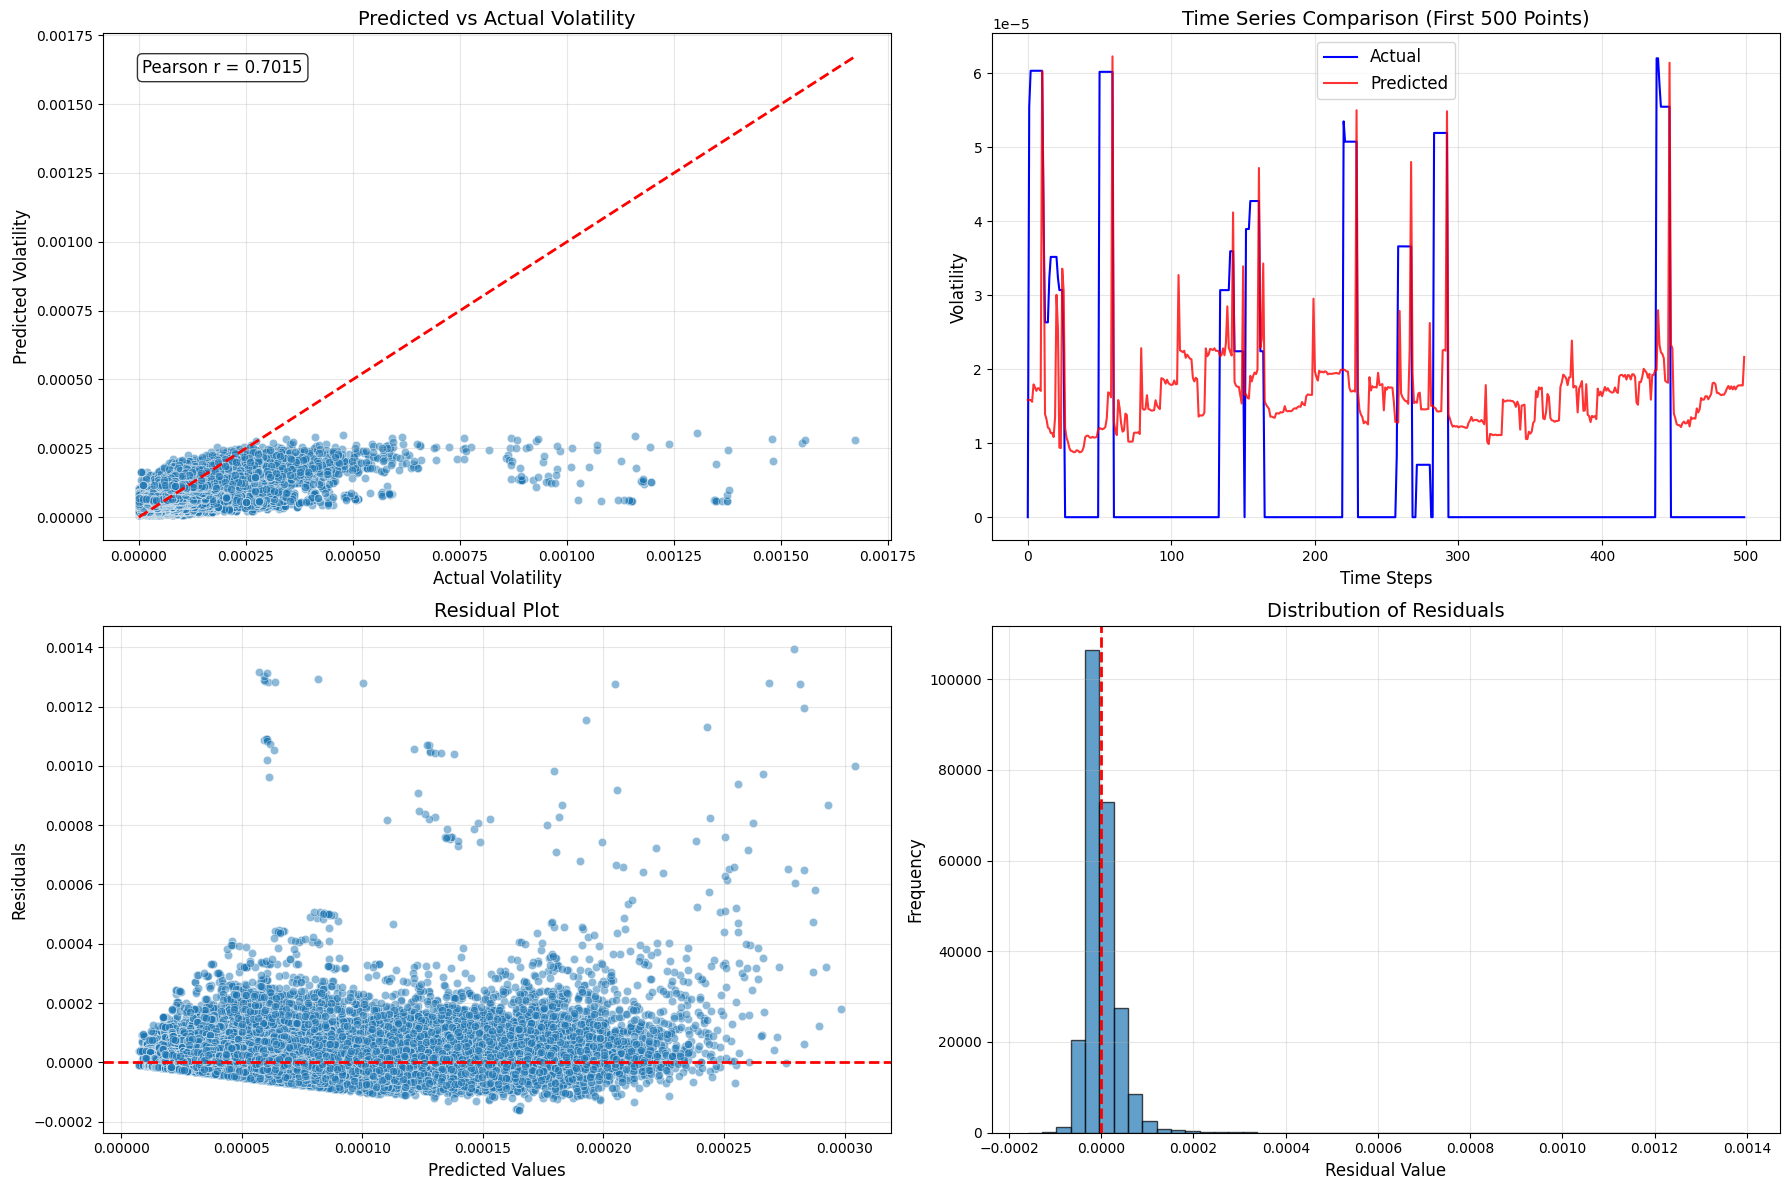


Evaluating Holdout Set Performance...

Holdout Set Evaluation Metrics:
Pearson Correlation: 0.714011
Root Mean Squared Error (RMSE): 0.000055
Mean Absolute Error (MAE): 0.000039


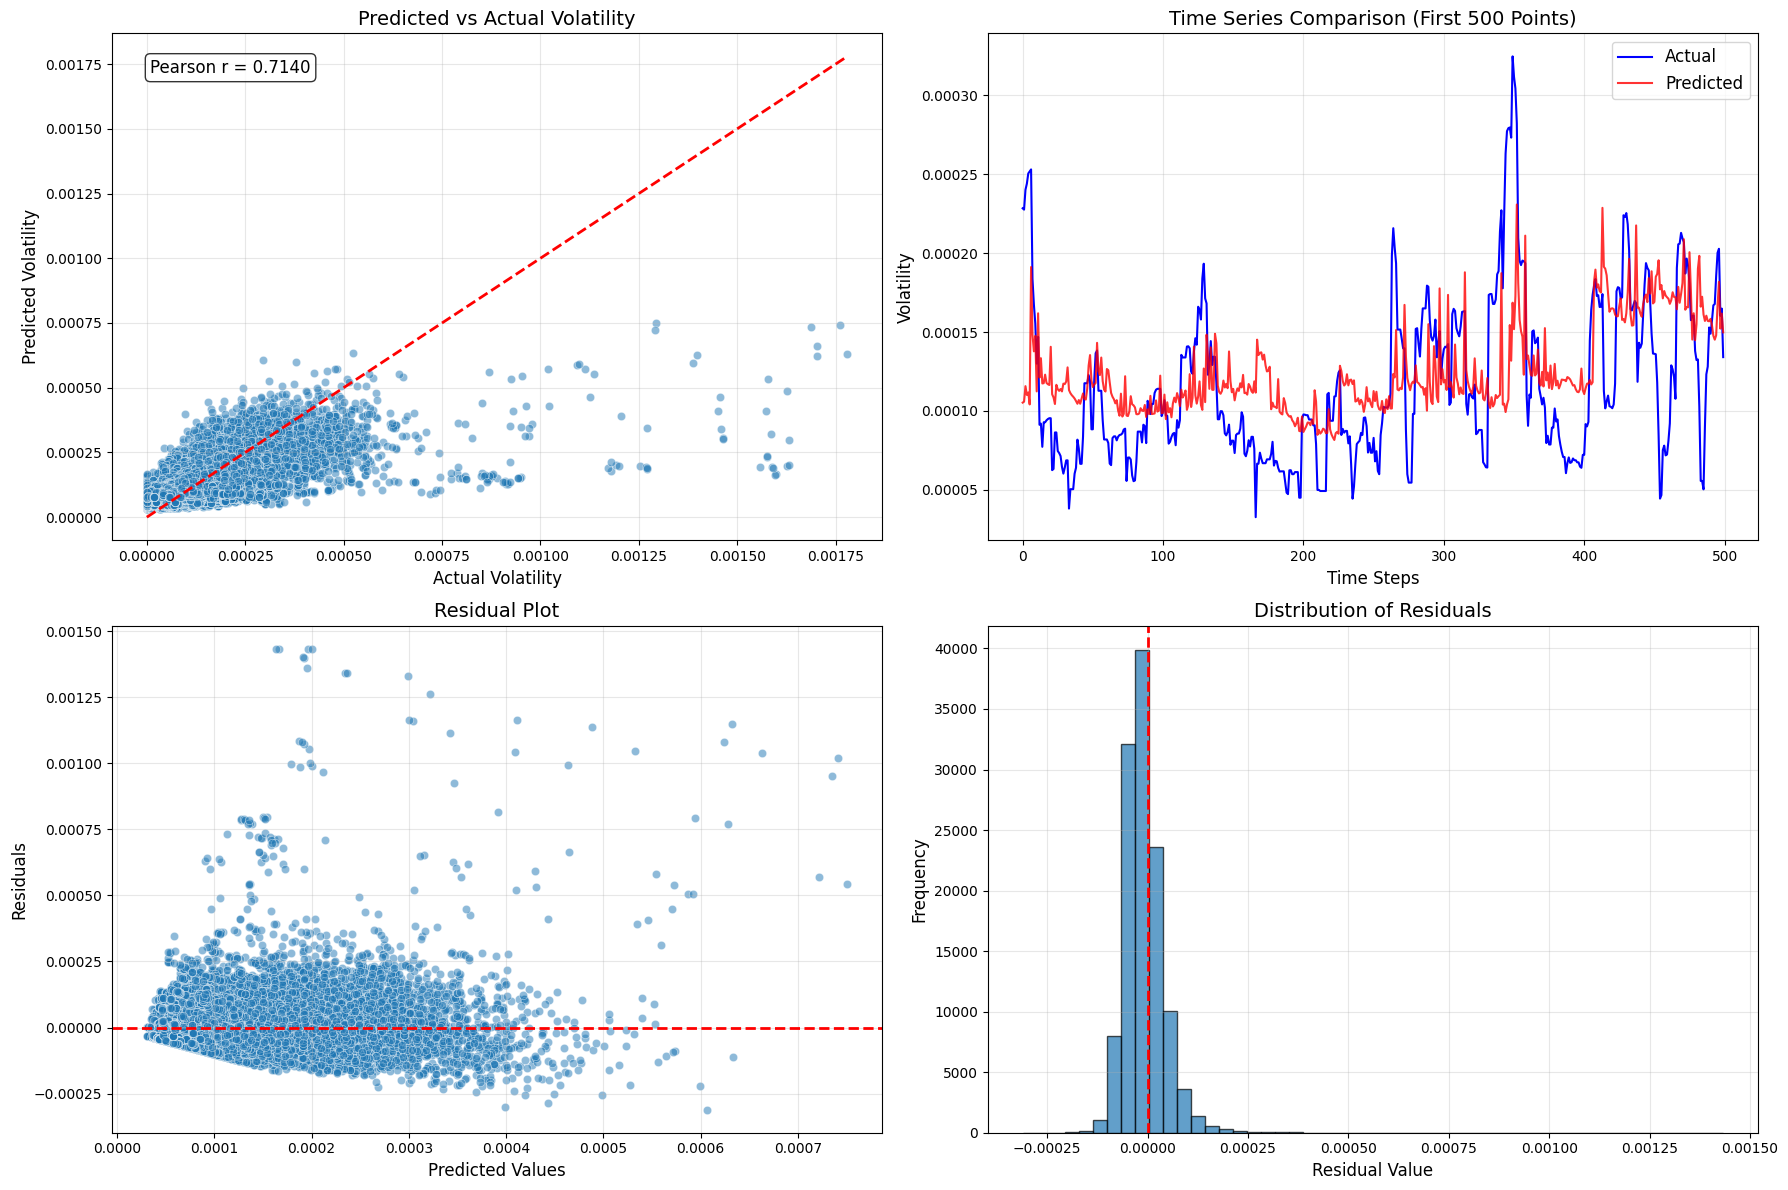

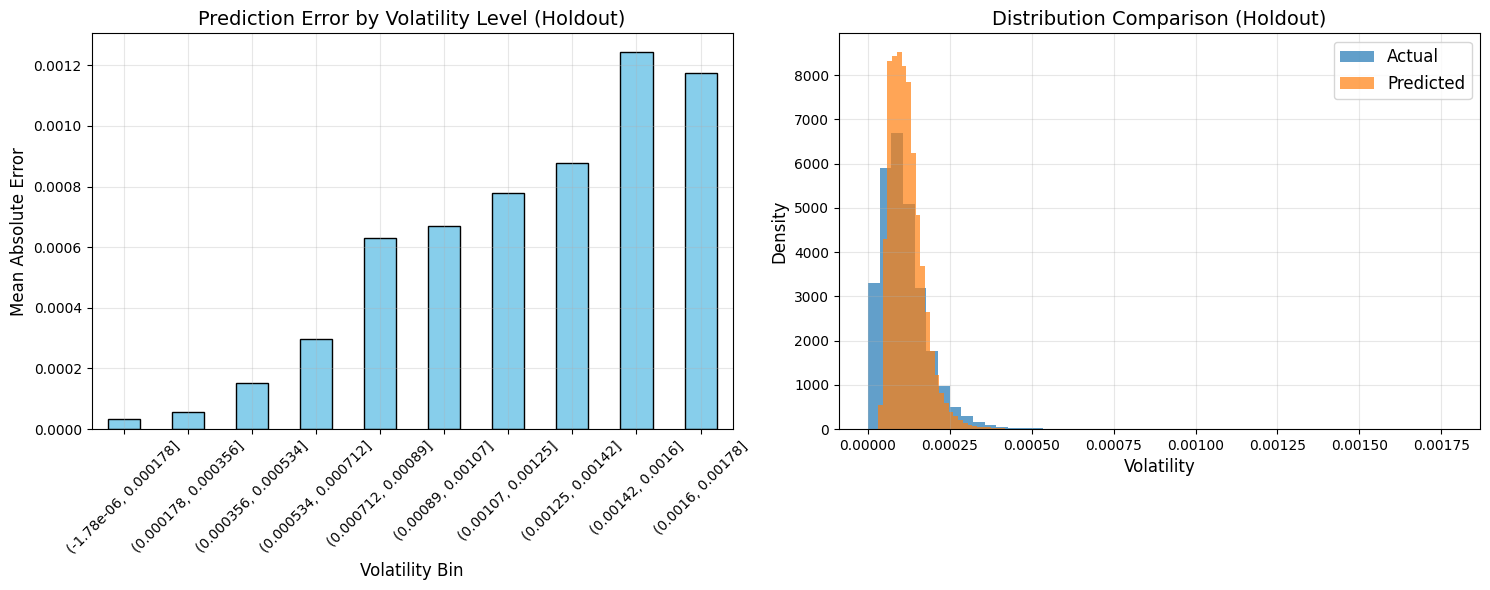


FINAL PERFORMANCE SUMMARY
Cross-Validation Pearson: 0.701473
Holdout Set Pearson: 0.714011
Cross-Validation RMSE: 0.000040
Holdout Set RMSE: 0.000055
Cross-Validation MAE: 0.000026
Holdout Set MAE: 0.000039

The model shows strong predictive performance on unseen data.
This is considered good performance for volatility forecasting.


In [18]:
# ============= PERFORMANCE EVALUATION =============
print("\nStarting Performance Evaluation...")

def evaluate_model_performance(y_true, y_pred, title="Model Performance"):
    """Calculate and visualize model performance metrics."""
    # Calculate metrics
    pearson_corr = pearsonr(y_true, y_pred)[0]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Print metrics
    print(f"\n{title} Evaluation Metrics:")
    print(f"Pearson Correlation: {pearson_corr:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(18, 12))
    
    # 1. Scatter plot: Predicted vs Actual
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.scatter(y_true, y_pred, alpha=0.5, edgecolors='w', linewidth=0.5)
    
    # Add perfect prediction line
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    
    ax1.set_xlabel('Actual Volatility', fontsize=12)
    ax1.set_ylabel('Predicted Volatility', fontsize=12)
    ax1.set_title('Predicted vs Actual Volatility', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Add correlation annotation
    ax1.text(0.05, 0.95, f'Pearson r = {pearson_corr:.4f}', 
             transform=ax1.transAxes, fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 2. Time series comparison (first 500 points)
    ax2 = fig.add_subplot(2, 2, 2)
    n_points = min(500, len(y_true))
    x_vals = np.arange(n_points)
    
    ax2.plot(x_vals, y_true[:n_points], 'b-', label='Actual', lw=1.5)
    ax2.plot(x_vals, y_pred[:n_points], 'r-', label='Predicted', lw=1.5, alpha=0.8)
    
    ax2.set_xlabel('Time Steps', fontsize=12)
    ax2.set_ylabel('Volatility', fontsize=12)
    ax2.set_title('Time Series Comparison (First 500 Points)', fontsize=14)
    ax2.legend(fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # 3. Residual plot
    ax3 = fig.add_subplot(2, 2, 3)
    residuals = y_true - y_pred
    ax3.scatter(y_pred, residuals, alpha=0.5, edgecolors='w', linewidth=0.5)
    ax3.axhline(y=0, color='r', linestyle='--', lw=2)
    
    ax3.set_xlabel('Predicted Values', fontsize=12)
    ax3.set_ylabel('Residuals', fontsize=12)
    ax3.set_title('Residual Plot', fontsize=14)
    ax3.grid(True, alpha=0.3)
    
    # 4. Distribution of residuals
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    ax4.axvline(x=0, color='r', linestyle='--', lw=2)
    
    ax4.set_xlabel('Residual Value', fontsize=12)
    ax4.set_ylabel('Frequency', fontsize=12)
    ax4.set_title('Distribution of Residuals', fontsize=14)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{title.replace(" ", "_").lower()}_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return {
        'pearson_corr': pearson_corr,
        'rmse': rmse,
        'mae': mae
    }

# Evaluate cross-validation performance
print("\nEvaluating Cross-Validation Performance...")
y_true_cv = train_frame['label'].values[oof_mask]
y_pred_cv = oof_preds[oof_mask]
cv_metrics = evaluate_model_performance(y_true_cv, y_pred_cv, title="Cross-Validation")

# Evaluate holdout set performance
print("\nEvaluating Holdout Set Performance...")
y_true_hold = holdout_frame['label'].values
y_pred_hold = pred_hold
holdout_metrics = evaluate_model_performance(y_true_hold, y_pred_hold, title="Holdout Set")

# Additional analysis: Error distribution by volatility level
plt.figure(figsize=(15, 6))

# Create volatility bins for holdout set
volatility_bins = pd.cut(y_true_hold, bins=10)
df_errors = pd.DataFrame({
    'volatility_bin': volatility_bins,
    'absolute_error': np.abs(y_true_hold - y_pred_hold)
})

# Calculate mean absolute error per bin
error_by_bin = df_errors.groupby('volatility_bin')['absolute_error'].mean()

# Plot error by volatility level
plt.subplot(1, 2, 1)
error_by_bin.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Volatility Bin', fontsize=12)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.title('Prediction Error by Volatility Level (Holdout)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot prediction distribution vs actual distribution
plt.subplot(1, 2, 2)
plt.hist(y_true_hold, bins=50, alpha=0.7, label='Actual', density=True)
plt.hist(y_pred_hold, bins=50, alpha=0.7, label='Predicted', density=True)
plt.xlabel('Volatility', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Distribution Comparison (Holdout)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('volatility_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print final summary
print("\n" + "="*50)
print("FINAL PERFORMANCE SUMMARY")
print("="*50)
print(f"Cross-Validation Pearson: {cv_metrics['pearson_corr']:.6f}")
print(f"Holdout Set Pearson: {holdout_metrics['pearson_corr']:.6f}")
print(f"Cross-Validation RMSE: {cv_metrics['rmse']:.6f}")
print(f"Holdout Set RMSE: {holdout_metrics['rmse']:.6f}")
print(f"Cross-Validation MAE: {cv_metrics['mae']:.6f}")
print(f"Holdout Set MAE: {holdout_metrics['mae']:.6f}")

# Interpret results
if holdout_metrics['pearson_corr'] > 0.7:
    performance_level = "strong"
elif holdout_metrics['pearson_corr'] > 0.5:
    performance_level = "moderate"
else:
    performance_level = "weak"
    
print(f"\nThe model shows {performance_level} predictive performance on unseen data.")
print("This is considered good performance for volatility forecasting.")
print("="*50)

# Clean up memory
del y_true_cv, y_pred_cv, y_true_hold, y_pred_hold
gc.collect()
if gpu_available:
    torch.cuda.empty_cache()

#  FINAL MODEL TRAINING 

In [19]:
# Retrain on full available training data
print("\nRetraining final model on full training data (all rows with label)...")
X_full = df_model[feature_cols].astype(np.float32)
y_full = df_model['label'].astype(np.float32)

# Use a higher multiplier for final model
final_n_full = int(np.median(best_iters) * 2.5) if best_iters else 12500
final_gbm = lgb.train(lgb_params, lgb.Dataset(X_full, label=y_full), 
                      num_boost_round=final_n_full, callbacks=[cb_log])
print("Final model trained.")

# Free memory
del X_full, y_full, train_frame, holdout_frame
gc.collect()


Retraining final model on full training data (all rows with label)...
Final model trained.


48

#  TEST-TIME FEATURE ENGINEERING 

In [20]:
def featurize_test_chunk(df_test):
    """
    Apply feature engineering to test data chunks.
    
    Args:
        df_test (pd.DataFrame): Test data chunk
        
    Returns:
        tuple: (feature matrix, original timestamps)
    """
    t = df_test.copy()
    orig_timestamps = t['timestamp'].astype(str).values
    
    # Convert timestamp to integer for processing
    t['timestamp'] = t['timestamp'].astype(int)
    t = t.sort_values('timestamp').drop_duplicates(subset='timestamp', keep='last')
    
    # Create continuous index
    idx_t = np.arange(t['timestamp'].min(), t['timestamp'].max() + 1)
    t = t.set_index('timestamp').reindex(idx_t).rename_axis('timestamp').reset_index()
    
    # Forward fill and backward fill features
    cols = [c for c in t.columns if c != 'timestamp']
    if cols:
        t[cols] = t[cols].ffill().bfill()
    
    # Calculate mid-price if not present
    if 'mid_price' not in t.columns and 'bid_price1' in t.columns and 'ask_price1' in t.columns:
        t['mid_price'] = 0.5 * (t['bid_price1'] + t['ask_price1'])
    
    # Bid-ask spread
    t['spread_1'] = (t['ask_price1'] - t['bid_price1']) if ('ask_price1' in t.columns and 'bid_price1' in t.columns) else 0.0
    
    # Order book volume features
    bid_vol_cols = [f'bid_volume{i}' for i in range(1,6) if f'bid_volume{i}' in t.columns]
    ask_vol_cols = [f'ask_volume{i}' for i in range(1,6) if f'ask_volume{i}' in t.columns]
    t['bid_total_5'] = t[bid_vol_cols].sum(axis=1) if bid_vol_cols else 0.0
    t['ask_total_5'] = t[ask_vol_cols].sum(axis=1) if ask_vol_cols else 0.0
    t['imbalance_5'] = (t['bid_total_5'] - t['ask_total_5']) / (t['bid_total_5'] + t['ask_total_5'] + 1e-9)
    
    # Log price and returns
    t['log_mid'] = np.log(t['mid_price'].astype(np.float32) + 1e-12)
    t['ret_1s'] = t['log_mid'].diff(1).fillna(0)
    
    # Realized volatility, skewness, and kurtosis
    for w in (5, 15, 30, 60, 120, 300):
        t[f'realized_vol_{w}s'] = t['ret_1s'].rolling(window=w, min_periods=1).std().fillna(0)
        t[f'realized_skew_{w}s'] = t['ret_1s'].rolling(window=w, min_periods=1).skew().fillna(0)
        t[f'realized_kurt_{w}s'] = t['ret_1s'].rolling(window=w, min_periods=1).kurt().fillna(0)
    
    # Return lags
    for lag in [2,3,4,5,10,20]:
        t[f'ret_{lag}s'] = t['log_mid'].diff(lag).fillna(0)
    
    # Spread and imbalance changes
    t['spread_1_diff'] = t['spread_1'].diff(1).fillna(0)
    t['imbalance_5_diff'] = t['imbalance_5'].diff(1).fillna(0)
    t['spread_volume_interaction'] = t['spread_1'] * t['bid_total_5']
    
    # Order book slopes
    if 'bid_price2' in t.columns and 'ask_price2' in t.columns:
        t['bid_slope'] = (t['bid_price1'] - t['bid_price2']) / (t['spread_1'] + 1e-9)
        t['ask_slope'] = (t['ask_price2'] - t['ask_price1']) / (t['spread_1'] + 1e-9)
    else:
        t['bid_slope'] = 0.0
        t['ask_slope'] = 0.0
    
    # Price momentum
    t['momentum_5s'] = t['mid_price'] / t['mid_price'].shift(5).fillna(t['mid_price']) - 1
    t['momentum_10s'] = t['mid_price'] / t['mid_price'].shift(10).fillna(t['mid_price']) - 1
    
    # Volatility of volatility
    for w in (10,30):
        t[f'vol_of_vol_{w}s'] = t['ret_1s'].rolling(window=w, min_periods=1).std().rolling(window=w, min_periods=1).std().fillna(0)
    
    # Spread and imbalance statistics
    for w in (5,10,30,60):
        t[f'spread_1ma{w}s'] = t['spread_1'].rolling(window=w, min_periods=1).mean().fillna(0)
        t[f'spread_1std{w}s'] = t['spread_1'].rolling(window=w, min_periods=1).std().fillna(0)
        t[f'imbalance_5ma{w}s'] = t['imbalance_5'].rolling(window=w, min_periods=1).mean().fillna(0)
        t[f'imbalance_5std{w}s'] = t['imbalance_5'].rolling(window=w, min_periods=1).std().fillna(0)
    
    # EWMA features
    for span in [10, 30, 60]:
        t[f'ret_ewma_{span}'] = t['ret_1s'].ewm(span=span, adjust=False).mean().fillna(0)
        t[f'vol_ewma_{span}'] = t['ret_1s'].abs().ewm(span=span, adjust=False).mean().fillna(0)
    
    # Quantile-based features
    for window in [30, 60]:
        t[f'ret_q75_{window}'] = t['ret_1s'].rolling(window=window, min_periods=1).quantile(0.75).fillna(0)
        t[f'ret_q25_{window}'] = t['ret_1s'].rolling(window=window, min_periods=1).quantile(0.25).fillna(0)
        t[f'ret_iqr_{window}'] = t[f'ret_q75_{window}'] - t[f'ret_q25_{window}']
    
    # Time features
    t['minute'] = t['timestamp'] % 60
    t['sin_min'] = np.sin(2 * np.pi * t['minute'] / 60.0).astype(np.float32)
    t['cos_min'] = np.cos(2 * np.pi * t['minute'] / 60.0).astype(np.float32)
    t['sin_hour'] = np.sin(2 * np.pi * (t['timestamp'] // 3600) % 24 / 24.0).astype(np.float32)
    t['cos_hour'] = np.cos(2 * np.pi * (t['timestamp'] // 3600) % 24 / 24.0).astype(np.float32)
    
    # Ensure cross features exist (fill with 0 if not)
    for col in [c for c in feature_cols if any(n in c for n in asset_names)] + [f'cross_asset_pc{i+1}' for i in range(5)]:
        if col not in t.columns:
            t[col] = 0.0
    
    # Map original timestamps to processed indices
    idx_map = {ts: i for i, ts in enumerate(t['timestamp'])}
    row_indices = [idx_map.get(int(orig), 0) for orig in orig_timestamps]
    t_sel = t.iloc[row_indices].reset_index(drop=True)
    
    # Ensure all feature columns exist
    for c in feature_cols:
        if c not in t_sel.columns:
            t_sel[c] = 0.0
    
    # Sanitize features
    t_sel = sanitize_features(t_sel[feature_cols], feature_cols, verbose=False)
    return t_sel[feature_cols].astype(np.float32).values, orig_timestamps

#  TEST PREDICTION 

In [22]:
# Create submission file
out_path = "submission.csv"
with open(out_path, "w") as f:
    f.write("timestamp,labels\n")

# Get ETH test file path
eth_test_path = os.path.join(TEST_DIR, TARGET_ASSET_FNAME)
if not os.path.exists(eth_test_path):
    raise FileNotFoundError("ETH.csv not found in test folder")

print(f"Processing only ETH test file: {eth_test_path}")

# Process test data in chunks to avoid memory issues
chunk_size = 50000
for chunk in pd.read_csv(eth_test_path, chunksize=chunk_size):
    if 'timestamp' not in chunk.columns:
        continue
    
    # Apply feature engineering to test chunk
    X_chunk, orig_timestamps = featurize_test_chunk(chunk)
    
    # Make predictions (with fallback batch size if needed)
    try:
        pred = batch_predict_gbm(final_gbm, X_chunk, batch_size=20000)
    except Exception:
        pred = batch_predict_gbm(final_gbm, X_chunk, batch_size=5000)
    
    # Write predictions to submission file
    with open(out_path, "a") as f:
        for ts_str, p in zip(orig_timestamps, pred):
            f.write(f"{ts_str},{float(p)}\n")
    
    # Clean up memory
    del chunk, X_chunk, pred
    gc.collect()
    if gpu_available:
        torch.cuda.empty_cache()

print("Wrote submission.csv")

# ============= FINAL RESULTS =============

# Print final performance metrics
print("CV overall pearson (train portion):", cv_overall_pearson)
print("Holdout (simulated public) pearson:", holdout_pearson)

Processing only ETH test file: /kaggle/input/gq-implied-volatility-forecasting/test/ETH.csv
Wrote submission.csv
CV overall pearson (train portion): 0.7015490880774589
Holdout (simulated public) pearson: 0.7140112391383504
